##### Tutorial on making the plot Interactive #####
https://saturncloud.io/blog/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook/#:~:text=To%20make%20our%203D%20plot,using%20our%20mouse%20or%20trackpad. 

In [1]:
# %matplotlib notebook
%matplotlib widget
%matplotlib inline
# I didn't have the line "%matplotlib inline" and then the plots weren't showing 

# What's really important is %matplotlib widget cause that's how I was able to make it interactive

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import numpy as np

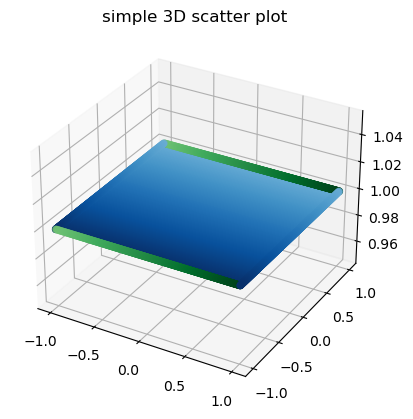

In [3]:
# Create green dots for left side of line
num_dots = 500

left_green = np.linspace(-1., 1., num_dots).reshape((-1, 1)) # x values
left_neg_ones = -1*np.ones((left_green.shape))
left_ones =  np.ones(left_green.shape)
left_green_points = np.concatenate((left_green, left_neg_ones, left_ones), axis=1)

right_green = np.linspace(-1., 1., num_dots).reshape((-1, 1))
right_neg_ones = np.ones((right_green.shape))
right_ones =  np.ones(right_green.shape)
right_green_points = np.concatenate((right_green, right_neg_ones, right_ones), axis=1)

# Creating figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

gradient = np.linspace(0.5, 1, num_dots)
green_colors = plt.cm.Greens(gradient)
blue_colors = plt.cm.Blues(gradient)

# FIX ME
# print(gradient.shape)
# print(np.array(plt.cm.Greens(1)).shape)
# print(np.array(plt.cm.Blues(1)).shape)
# mixed_colors = (1 - gradient) * np.array(plt.cm.Greens(1)) + gradient * np.array(plt.cm.Blues(1))

# Creating plot
ax.scatter(left_green_points[:, 0], left_green_points[:, 1], left_green_points[:, 2], c=green_colors)
ax.scatter(right_green_points[:, 0], right_green_points[:, 1], right_green_points[:, 2], c=green_colors)
for i in range(left_green.shape[0]):
    ax.plot([left_green_points[i, 0], right_green_points[i, 0]], [left_green_points[i, 1], right_green_points[i, 1]], [left_green_points[i, 2], right_green_points[i, 2]], c=green_colors[i], linewidth=1)

# Rotate the green points to obtain blue points
angle = np.pi/2
rotation_matrix = np.array([
    [np.cos(angle), -np.sin(angle), 0],
    [np.sin(angle), np.cos(angle), 0],
    [0, 0, 1]
])

left_blue = np.linspace(-1., 1., num_dots).reshape((-1, 1))
left_blue_points = np.dot(left_green_points, rotation_matrix)
right_blue = np.linspace(-1., 1., num_dots).reshape((-1, 1))
right_blue_points = np.dot(right_green_points, rotation_matrix)

# Creating plot
ax.scatter(left_blue_points[:, 0], left_blue_points[:, 1], left_blue_points[:, 2], c=blue_colors)
ax.scatter(right_blue_points[:, 0], right_blue_points[:, 1], right_blue_points[:, 2], c=blue_colors)
for i in range(left_blue.shape[0]):
    ax.plot([left_blue_points[i, 0], right_blue_points[i, 0]], [left_blue_points[i, 1], right_blue_points[i, 1]], [left_blue_points[i, 2], right_blue_points[i, 2]], c=blue_colors[i], linewidth=1)

# show plots
plt.title("simple 3D scatter plot")
plt.show()


# TODO: Draw a line between all of these points using a for loop

# print(left_green_points)



### Demo of how the 3d plot should work with a triangle

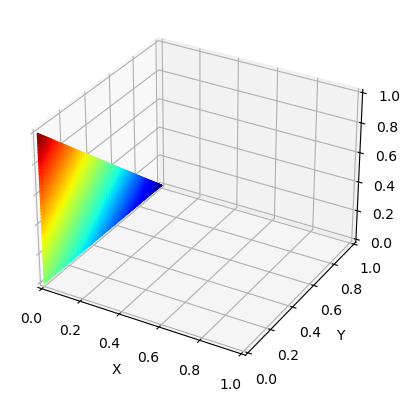

In [4]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
points=50
Y, Z = np.meshgrid(np.linspace(0,1,points), np.linspace(0,1,points)) 
Z = Z*(1-Y)
color =(1-Y+Z)*0.5

ax.plot_surface(np.zeros_like(Y), Y, Z, facecolors=plt.cm.jet(color), 
                rcount=points, ccount=points, shade=False)

ax.set_xlabel('X')
ax.set_xlim(0, 1)
ax.set_ylabel('Y')
ax.set_ylim(0,1)
ax.set_zlabel('Z')
ax.set_zlim(0,1)    
plt.show()

/var/folders/x0/9q9n7mkn07z62hr6_4xxv6hc0000gn/T/ipykernel_9157/2977958132.py:76: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_grid, Y_grid, Z_grid, c=color_new, cmap=custom_cmap, s=50, marker='o')


IndexError: index 2 is out of bounds for axis 1 with size 2

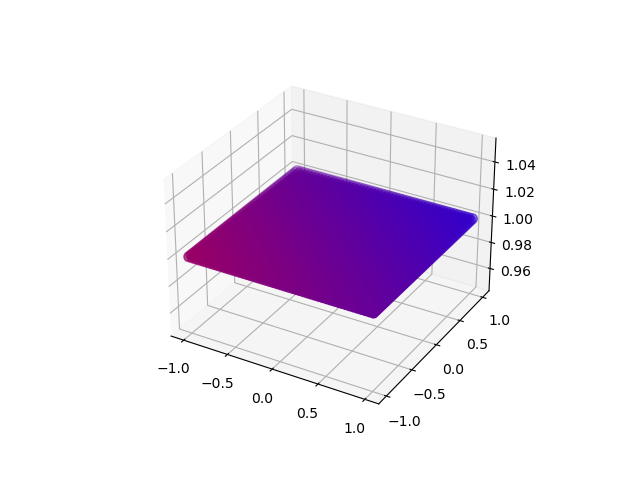

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import normalize
import cv2

# Create a custom colormap
cmap_colors = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
cmap_colors_transformation = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)
custom_cmap_transformation = LinearSegmentedColormap.from_list('custom_transformation', cmap_colors_transformation)

# Create a 2D grid of values for both dimensions
num_dimensions = 2
num_points = 50
lowest_color_value = 0.2
highest_color_value = 0.8
z_value = 1.
x_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
y_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
X_color, Y_color = np.meshgrid(x_color, y_color)

# Combine data for both dimensions into a single variable
combined_data = X_color + Y_color  # You can use a different combination as needed

# Apply the custom colormap to the combined data
color = custom_cmap(combined_data)

# Make sure the color is in the right form (num of data points x 4), so we have a 
# color for each datapoint
color_new = color.reshape((-1, 4))
color_new_transformation = np.copy(color_new)

# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the boundaries of the square we are creating
min_x = -1
max_x = 1

min_y = -1
max_y = 1

z_value = 1
z_value_transformation = 2

# Create a grid of x and y values that will be the points of our "plane"
x_grid = np.linspace(min_x, max_x, num_points)
y_grid = np.linspace(min_y, max_y, num_points)

# Use np.meshgrid and reshaping to make this into a collection of points 
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
X_grid = X_grid.reshape((-1, 1))
Y_grid = Y_grid.reshape((-1, 1))
Z_grid = np.full(X_grid.shape, z_value)

points_3D = np.concatenate((X_grid, Y_grid, Z_grid), axis=1)

# Create a different z value to distinguish original and transformed matrix
Z_grid_2s = np.full(Z_grid.shape, z_value_transformation)

# Create transformed matrix
points_3D_of_2s = points_3D[:,:2]

points_3D_test = np.concatenate((points_3D_of_2s, Z_grid_2s), axis=1)

rotation_matrix = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
points_3D_rotate = np.matmul(points_3D_test, rotation_matrix)

points_3D_test = points_3D_rotate

H, _ = cv2.findHomography(points_3D_test[:, :2], points_3D[:, :2])
points_2D = cv2.perspectiveTransform(np.array([points_3D_test[:, :2]]), H)

ax.scatter(X_grid, Y_grid, Z_grid, c=color_new, cmap=custom_cmap, s=50, marker='o')
ax.scatter(points_2D[0][:, 0], points_2D[0][:, 1], Z_grid_2s, c=color_new_transformation, cmap=custom_cmap_transformation, s=50, marker='o')

# Plot the 3D grid with the colormap representing both dimensions for both the original and the transformed matrix
# ax.scatter(X_grid, Y_grid, Z_grid, c=color_new, cmap=custom_cmap, s=50, marker='o')
# ax.scatter(points_3D_test[:,0], points_3D_test[:,1], points_3D_test[:,2], c=color_new_transformation, cmap=custom_cmap_transformation, s=50, marker='o')

# Set the 3D axis limits so we can view everything
min_val = min(points_3D_test.flatten())
max_val = max(points_3D_test.flatten())

ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

ax.set_zlim(min_val, max_val)

# Show the plot
plt.show()

#### Homography Explained With Code ####
https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html 

#### Youtube Video Explaining Homography ####

- 2x2 Image Transformations: https://youtu.be/K2XLXlyPqCA 

- 3x3 Image Transformations: https://www.youtube.com/watch?v=B8kMB6Hv2eI

- Homography: https://www.youtube.com/watch?v=l_qjO4cM74o 

- Homograph Examples using OpenCV: https://learnopencv.com/homography-examples-using-opencv-python-c/